In [4]:
import os
import pandas as pd
from scipy.stats import linregress
import scipy as sts
import scipy.stats as st
import seaborn as sns
import numpy as np
import pylab as pl
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.ticker import FuncFormatter
import datetime as datetime
import gmaps
import requests
import json
%matplotlib notebook

In [5]:
world_df= pd.read_csv("../Resources/owid-covid-data.csv")

#Unsing total_deaths column and total_cases_per_million, total cases, new cases
updated_world_df=world_df.drop(["iso_code","new_deaths_per_million","total_tests","new_tests",
                                "new_tests_smoothed_per_thousand","population","median_age","aged_70_older",
                                "extreme_poverty","female_smokers","male_smokers",
                               "handwashing_facilities","hospital_beds_per_thousand","life_expectancy",
                               "new_tests_smoothed","new_tests_per_thousand","tests_units",
                               "new_deaths","new_cases_per_million"], axis=1)

updated_world_df=updated_world_dfupdated_world_df=updated_world_df.rename(columns={"location":"Country", "continent":"Continent","date":"Date",
                                                    "total_cases":"Total Cases", "new_cases":"New Cases",
                                                    "total_cases_per_million": "Total Cases Per Million",
                                                  "total_deaths_per_million":"Total Deaths Per Million",
                                                  "total_tests_per_thousand":"Total Test Per Thousands",
                                                 "population_density":"Population Density","aged_65_older":"Aged 65 or older",
                                                 "gdp_per_capita":"GDP Per Capita","cvd_death_rate":"Covid Death Rate",
                                                 "stringency_index":"Stringency Index","total_deaths":"Total Deaths"})

#updated_world_df.fillna(0, inplace=True)

updated_world_df.head()

,Continent,Country,Date,Total Cases,New Cases,Total Deaths,Total Cases Per Million,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,Population Density,Aged 65 or older,GDP Per Capita,Covid Death Rate,diabetes_prevalence
0,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,NaN,NaN,54.422,2.581,1803.987,597.029,9.59
1,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59
2,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59
3,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59
4,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,NaN,0.0,54.422,2.581,1803.987,597.029,9.59


In [6]:
#Number Hospital Beds is based on the lastest year per Country

data = pd.read_csv("../Resources/data.csv")

who_df = data.iloc[data.groupby("Country")["Year"].agg(pd.Series.idxmax)]
who_df.reset_index(drop=True).set_index("Country")
who_df=who_df.rename(columns={"Hospital beds (per 10 000 population)":"Hospital Beds (per 10K people)"})
hospital_beds_df=who_df.drop(["Year"], axis=1)

hospital_beds_df.head()

,Country,Hospital Beds (per 10K people)
0,Afghanistan,5
16,Albania,29
29,Algeria,19
31,Angola,8
32,Antigua and Barbuda,38


In [7]:
#Smoking Percentage is based on the lastest year per Country

smokingdata = pd.read_csv("../Resources/smokingdata.csv")

smokingdata_df = smokingdata.iloc[smokingdata.groupby("Country")["Year"].agg(pd.Series.idxmax)]

clean_smoking_data = smokingdata_df.drop(["Estimate of current cigarette smoking prevalence (%).1", "Estimate of current cigarette smoking prevalence (%).2", 
                                       "Estimate of current tobacco smoking prevalence (%)", "Estimate of current tobacco smoking prevalence (%).1", 
                                       "Estimate of current tobacco smoking prevalence (%).2", "Estimate of current tobacco use prevalence (%)", 
                                       "Estimate of current tobacco use prevalence (%).1", "Estimate of current tobacco use prevalence (%).2"], axis=1)

 
clean_smoking_data=clean_smoking_data.rename(columns={"Estimate of current cigarette smoking prevalence (%)":"Smoking Prevalence (%)"})
smoking_data = clean_smoking_data
smoking_prevalence=list(smoking_data["Smoking Prevalence (%)"])
smoking_percentage=[]

for x in smoking_prevalence:
    y=x.split("[")
    smoking_percentage.append(y[0])
    

    
column_values = pd.Series(smoking_percentage)
smoking_data.insert(loc=2, column="Smoking Percetage", value=column_values)
smoking_year_df=smoking_data.drop(["Smoking Prevalence (%)"], axis=1)

smoking_df=smoking_year_df.drop(["Year"], axis=1)

smoking_df.head()

,Country,Smoking Percetage
1,Albania,11.20
7,Algeria,15.20
13,Andorra,21.40
19,Argentina,31.40
25,Armenia,6.00


In [8]:
world_df=pd.read_csv("../Resources/dsh_simple.csv")

world_df=world_df[["Countryname","IfclosedduetoCOVID19whend","Statusof Schoolsaresomeall (copy) (group)",
          "Latitude (generated)","Longitude (generated)","Incomelevelname"]]

income_level_df=world_df.rename(columns={"Countryname":"Country", "Latitude (generated)":"Latitude", 
                      "Longitude (generated)": "Longitude", "Incomelevelname": "Income Level",
                        "Statusof Schoolsaresomeall (copy) (group)":"School Status"})
income_df=income_level_df.drop(["IfclosedduetoCOVID19whend"], axis =1)

income_df.head()

,Country,School Status,Latitude,Longitude,Income Level
0,Eritrea,Closed,15.9820,38.0200,Low income
1,Guinea-Bissau,Closed,12.1910,-14.4750,Low income
2,San Marino,Closed,43.9420,12.4611,High income
3,Georgia,Closed,42.0500,43.5760,Upper middle income
4,Italy,Closed,44.3713,11.1084,High income


In [9]:
combined_df=pd.merge(updated_world_df,hospital_beds_df,on="Country",how="left").merge(smoking_df,on="Country",how="left" ).merge(income_df,on="Country",how="left")

combined_df.head()

,Continent,Country,Date,Total Cases,New Cases,Total Deaths,Total Cases Per Million,Total Deaths Per Million,Total Test Per Thousands,Stringency Index,...,Aged 65 or older,GDP Per Capita,Covid Death Rate,diabetes_prevalence,Hospital Beds (per 10K people),Smoking Percetage,School Status,Latitude,Longitude,Income Level
0,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.023,65.5267,Low income
1,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.023,65.5267,Low income
2,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.023,65.5267,Low income
3,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.023,65.5267,Low income
4,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,2.581,1803.987,597.029,9.59,5.0,NaN,Closed,34.023,65.5267,Low income


In [7]:
#DATA CLEANING

strigency_per_country = combined_df[["Country","Date","Total Cases","Total Cases Per Million",
                                     "New Cases","Total Deaths Per Million",
                                     "Total Deaths","Stringency Index",
                                     "GDP Per Capita","Income Level",
                                    "Continent"]]
strigency_per_country.fillna(0, inplace=True)

#countries without Stringency Index and Number of Tests
no_stringency = strigency_per_country.groupby(["Country"]).mean()
no_stringency_countries = no_stringency[no_stringency["Stringency Index"] == 0].copy()
no_stringency_country_list = no_stringency_countries.index.tolist().copy()

#remove from list countries withouth Stringency Index and Number of Tests
for country in no_stringency_country_list:
    index = strigency_per_country[strigency_per_country["Country"] == country].index.copy()
    strigency_per_country.drop(index, inplace = True)

strigency_per_country.head(5)    

/Users/angelaromansivirichi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/Users/angelaromansivirichi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Country,Date,Total Cases,Total Cases Per Million,New Cases,Total Deaths Per Million,Total Deaths,Stringency Index,GDP Per Capita,Income Level,Continent
0,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,1803.987,Low income,Asia
1,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,1803.987,Low income,Asia
2,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,1803.987,Low income,Asia
3,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,1803.987,Low income,Asia
4,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,1803.987,Low income,Asia


In [8]:
#Drop San Marino From Data Frame
strigency_per_country_f = strigency_per_country[strigency_per_country["Country"] != "San Marino"]

strigency_per_country_f 

,Country,Date,Total Cases,Total Cases Per Million,New Cases,Total Deaths Per Million,Total Deaths,Stringency Index,GDP Per Capita,Income Level,Continent
0,Afghanistan,2019-12-31,0.0,0.000,0.0,0.000,0.0,0.0,1803.987,Low income,Asia
1,Afghanistan,2020-01-01,0.0,0.000,0.0,0.000,0.0,0.0,1803.987,Low income,Asia
2,Afghanistan,2020-01-02,0.0,0.000,0.0,0.000,0.0,0.0,1803.987,Low income,Asia
3,Afghanistan,2020-01-03,0.0,0.000,0.0,0.000,0.0,0.0,1803.987,Low income,Asia
4,Afghanistan,2020-01-04,0.0,0.000,0.0,0.000,0.0,0.0,1803.987,Low income,Asia
...,...,...,...,...,...,...,...,...,...,...,...
25253,Zimbabwe,2020-06-18,401.0,26.980,7.0,0.269,4.0,0.0,1899.775,Lower middle income,Africa
25254,Zimbabwe,2020-06-19,463.0,31.151,62.0,0.269,4.0,0.0,1899.775,Lower middle income,Africa
25255,Zimbabwe,2020-06-20,479.0,32.228,16.0,0.269,4.0,0.0,1899.775,Lower middle income,Africa
25256,Zimbabwe,2020-06-21,486.0,32.699,7.0,0.404,6.0,0.0,1899.775,Lower middle income,Africa


In [9]:
max_stringency = strigency_per_country_f .groupby("Country").agg({"Stringency Index":"max"})
max_total_deaths_permillion = strigency_per_country_f .groupby("Country").agg({"Total Deaths Per Million":"max"})
max_total_deaths = strigency_per_country_f .groupby("Country").agg({"Total Deaths":"max"})
max_total_cases = strigency_per_country_f .groupby("Country").agg({"Total Cases Per Million":"max"})
income = strigency_per_country_f .groupby("Country").agg({"Income Level":"unique"})
continent = strigency_per_country_f .groupby("Country").agg({"Continent":"unique"})

combined_stringency = pd.merge(max_stringency,max_total_deaths_permillion,on="Country",how="inner").merge(income,on="Country",how="inner").merge(max_total_deaths, on="Country", how="left").merge(max_total_cases, on="Country", how="left").merge(continent, on="Country", how="left")

combined_stringency_df = combined_stringency[combined_stringency["Income Level"] != 0]
combined_stringency_df

income=[]
continent_list=[]
for index, row in combined_stringency_df.iterrows():
    x=row["Income Level"][0]
    y=row["Continent"][0]
    income.append(x)
    continent_list.append(y)
    
combined_stringency_df["Country Income Level"]=income
combined_stringency_df["Continents"]=continent_list   
    
combined_stg_df = combined_stringency_df.reset_index()
combined_stg_df.head()


/Users/angelaromansivirichi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/angelaromansivirichi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Country,Stringency Index,Total Deaths Per Million,Income Level,Total Deaths,Total Cases Per Million,Continent,Country Income Level,Continents
0,Afghanistan,84.26,14.925,[Low income],581.0,740.669,[Asia],Low income,Asia
1,Albania,89.81,15.289,[Upper middle income],44.0,669.609,[Europe],Upper middle income,Europe
2,Algeria,92.13,19.270,[Upper middle income],845.0,268.431,[Africa],Upper middle income,Africa
3,Angola,90.74,0.274,[Lower middle income],9.0,5.355,[Africa],Lower middle income,Africa
4,Argentina,100.00,22.369,[Upper middle income],1011.0,946.372,[South America],Upper middle income,South America


In [10]:
#COUNTRIES WITH HIGHEST STRINGENCY INDEXES
sorted_stg = combined_stg_df.sort_values("Stringency Index",ascending=False )
sorted_stg.head(15)

,Country,Stringency Index,Total Deaths Per Million,Income Level,Total Deaths,Total Cases Per Million,Continent,Country Income Level,Continents
73,Kuwait,100.00,76.337,[High income],326.0,9284.490,[Asia],High income,Asia
59,Honduras,100.00,36.650,[Lower middle income],363.0,1289.198,[North America],Lower middle income,North America
107,Philippines,100.00,10.668,[Lower middle income],1169.0,274.244,[Asia],Lower middle income,Asia
125,Sri Lanka,100.00,0.514,[Upper middle income],11.0,91.065,[Asia],Upper middle income,Asia
39,Djibouti,100.00,45.546,[Lower middle income],45.0,4637.642,[Africa],Lower middle income,Africa
43,El Salvador,100.00,16.497,[Lower middle income],107.0,713.206,[North America],Lower middle income,North America
51,Georgia,100.00,3.509,[Upper middle income],14.0,227.616,[Asia],Upper middle income,Asia
78,Libya,100.00,1.455,[Upper middle income],10.0,79.170,[Africa],Upper middle income,Africa
116,Serbia,100.00,38.356,[Upper middle income],261.0,1894.896,[Europe],Upper middle income,Europe
62,India,100.00,9.927,[Lower middle income],13699.0,308.174,[Asia],Lower middle income,Asia


In [11]:
#COUNTRIES WITH LOWEST STRINGENCY INDEXES
sorted_stg = combined_stg_df.sort_values("Stringency Index")
sorted_stg.head(5)

,Country,Stringency Index,Total Deaths Per Million,Income Level,Total Deaths,Total Cases Per Million,Continent,Country Income Level,Continents
97,Nicaragua,16.67,9.661,[Lower middle income],64.0,304.020,[North America],Lower middle income,North America
12,Belarus,19.44,36.616,[Upper middle income],346.0,6191.450,[Europe],Upper middle income,Europe
24,Burundi,22.22,0.084,[Low income],1.0,12.110,[Africa],Low income,Africa
128,Sweden,46.30,500.333,[High income],5053.0,5549.213,[Europe],High income,Europe
69,Japan,47.22,7.535,[High income],953.0,141.655,[Asia],High income,Asia


In [12]:
#COUNTRIES WITH HIGHEST TOTAL NUMBER OF DEATHS PER MILLION
top_totaldeaths_permillion =  sorted_stg[sorted_stg["Total Deaths Per Million"]>200]
top_totaldeaths_permillion_df = top_totaldeaths_permillion.sort_values(by=["Total Deaths Per Million"], ascending=False).reset_index(drop=True)
top_totaldeaths_permillion_df.head(10)

,Country,Stringency Index,Total Deaths Per Million,Income Level,Total Deaths,Total Cases Per Million,Continent,Country Income Level,Continents
0,Belgium,81.48,836.611,[High income],9696.0,5224.504,[Europe],High income,Europe
1,United Kingdom,75.93,627.994,[High income],42632.0,4482.971,[Europe],High income,Europe
2,Spain,85.19,614.953,[High income],28752.0,5267.311,[Europe],High income,Europe
3,Italy,93.52,572.824,[High income],34634.0,3944.621,[Europe],High income,Europe
4,Sweden,46.30,500.333,[High income],5053.0,5549.213,[Europe],High income,Europe
5,France,90.74,454.089,[High income],29640.0,2457.000,[Europe],High income,Europe
6,United States,72.69,362.459,[High income],119975.0,6890.918,[North America],High income,North America
7,Netherlands,79.63,355.416,[High income],6090.0,2894.273,[Europe],High income,Europe
8,Ireland,90.74,347.321,[High income],1715.0,5139.743,[Europe],High income,Europe
9,Peru,96.30,243.996,[Upper middle income],8045.0,7731.930,[South America],Upper middle income,South America


In [13]:
#COUNTRIES WITH HIGHEST TOTAL NUMBER OF DEATHS 
top_totaldeaths =  sorted_stg[sorted_stg["Total Deaths"]>7800]
top_totaldeaths_df = top_totaldeaths.sort_values(by=["Total Deaths"], ascending=False).reset_index(drop=True)
top_totaldeaths_df.head()

,Country,Stringency Index,Total Deaths Per Million,Income Level,Total Deaths,Total Cases Per Million,Continent,Country Income Level,Continents
0,United States,72.69,362.459,[High income],119975.0,6890.918,[North America],High income,North America
1,Brazil,81.02,238.131,[Upper middle income],50617.0,5104.634,[South America],Upper middle income,South America
2,United Kingdom,75.93,627.994,[High income],42632.0,4482.971,[Europe],High income,Europe
3,Italy,93.52,572.824,[High income],34634.0,3944.621,[Europe],High income,Europe
4,France,90.74,454.089,[High income],29640.0,2457.000,[Europe],High income,Europe


In [14]:
#COUNTRIES WITH HIGHEST TOTAL CASES PER MILLION
top_cases_permillion =  sorted_stg[sorted_stg["Total Cases Per Million"]>5500]
top_cases_permillion_df = top_cases_permillion.sort_values(by=["Total Cases Per Million"], ascending=False).reset_index(drop=True)
top_cases_permillion_df

,Country,Stringency Index,Total Deaths Per Million,Income Level,Total Deaths,Total Cases Per Million,Continent,Country Income Level,Continents
0,Qatar,86.11,34.015,[High income],98.0,30325.297,[Asia],High income,Asia
1,Bahrain,78.70,37.024,[High income],63.0,12790.443,[Asia],High income,Asia
2,Chile,78.24,234.304,[High income],4479.0,12677.984,[South America],High income,South America
3,Kuwait,100.00,76.337,[High income],326.0,9284.490,[Asia],High income,Asia
4,Peru,96.30,243.996,[Upper middle income],8045.0,7731.930,[South America],Upper middle income,South America
5,Singapore,85.19,4.444,[High income],26.0,7195.305,[Asia],High income,Asia
6,United States,72.69,362.459,[High income],119975.0,6890.918,[North America],High income,North America
7,Luxembourg,79.63,175.726,[High income],110.0,6581.722,[Europe],High income,Europe
8,Belarus,19.44,36.616,[Upper middle income],346.0,6191.450,[Europe],Upper middle income,Europe
9,Panama,93.52,116.113,[High income],501.0,6032.769,[North America],High income,North America


In [16]:
fig = px.scatter(combined_stg_df, x = "Stringency Index", y = "Total Deaths Per Million", 
                facet_col="Continents", hover_name = "Country", trendline="ols", color="Continents",
                labels = {"Stringency Index":"Stringency Index"})
fig.update_layout(title="Stringency Index vs Total Deaths Per Million per Continent")
fig.show()

<IPython.core.display.Javascript object>


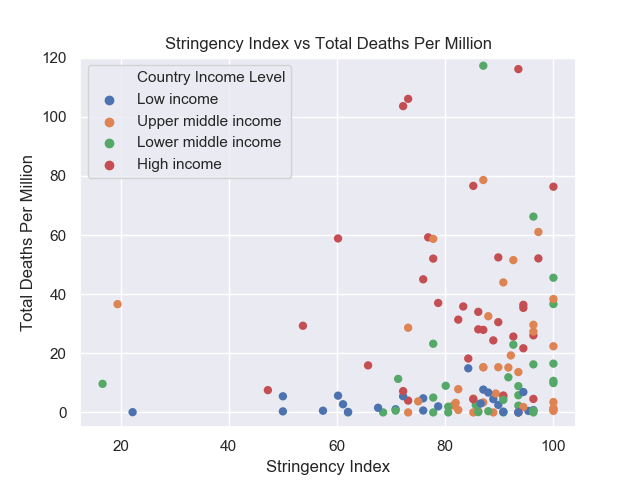

<IPython.core.display.Javascript object>


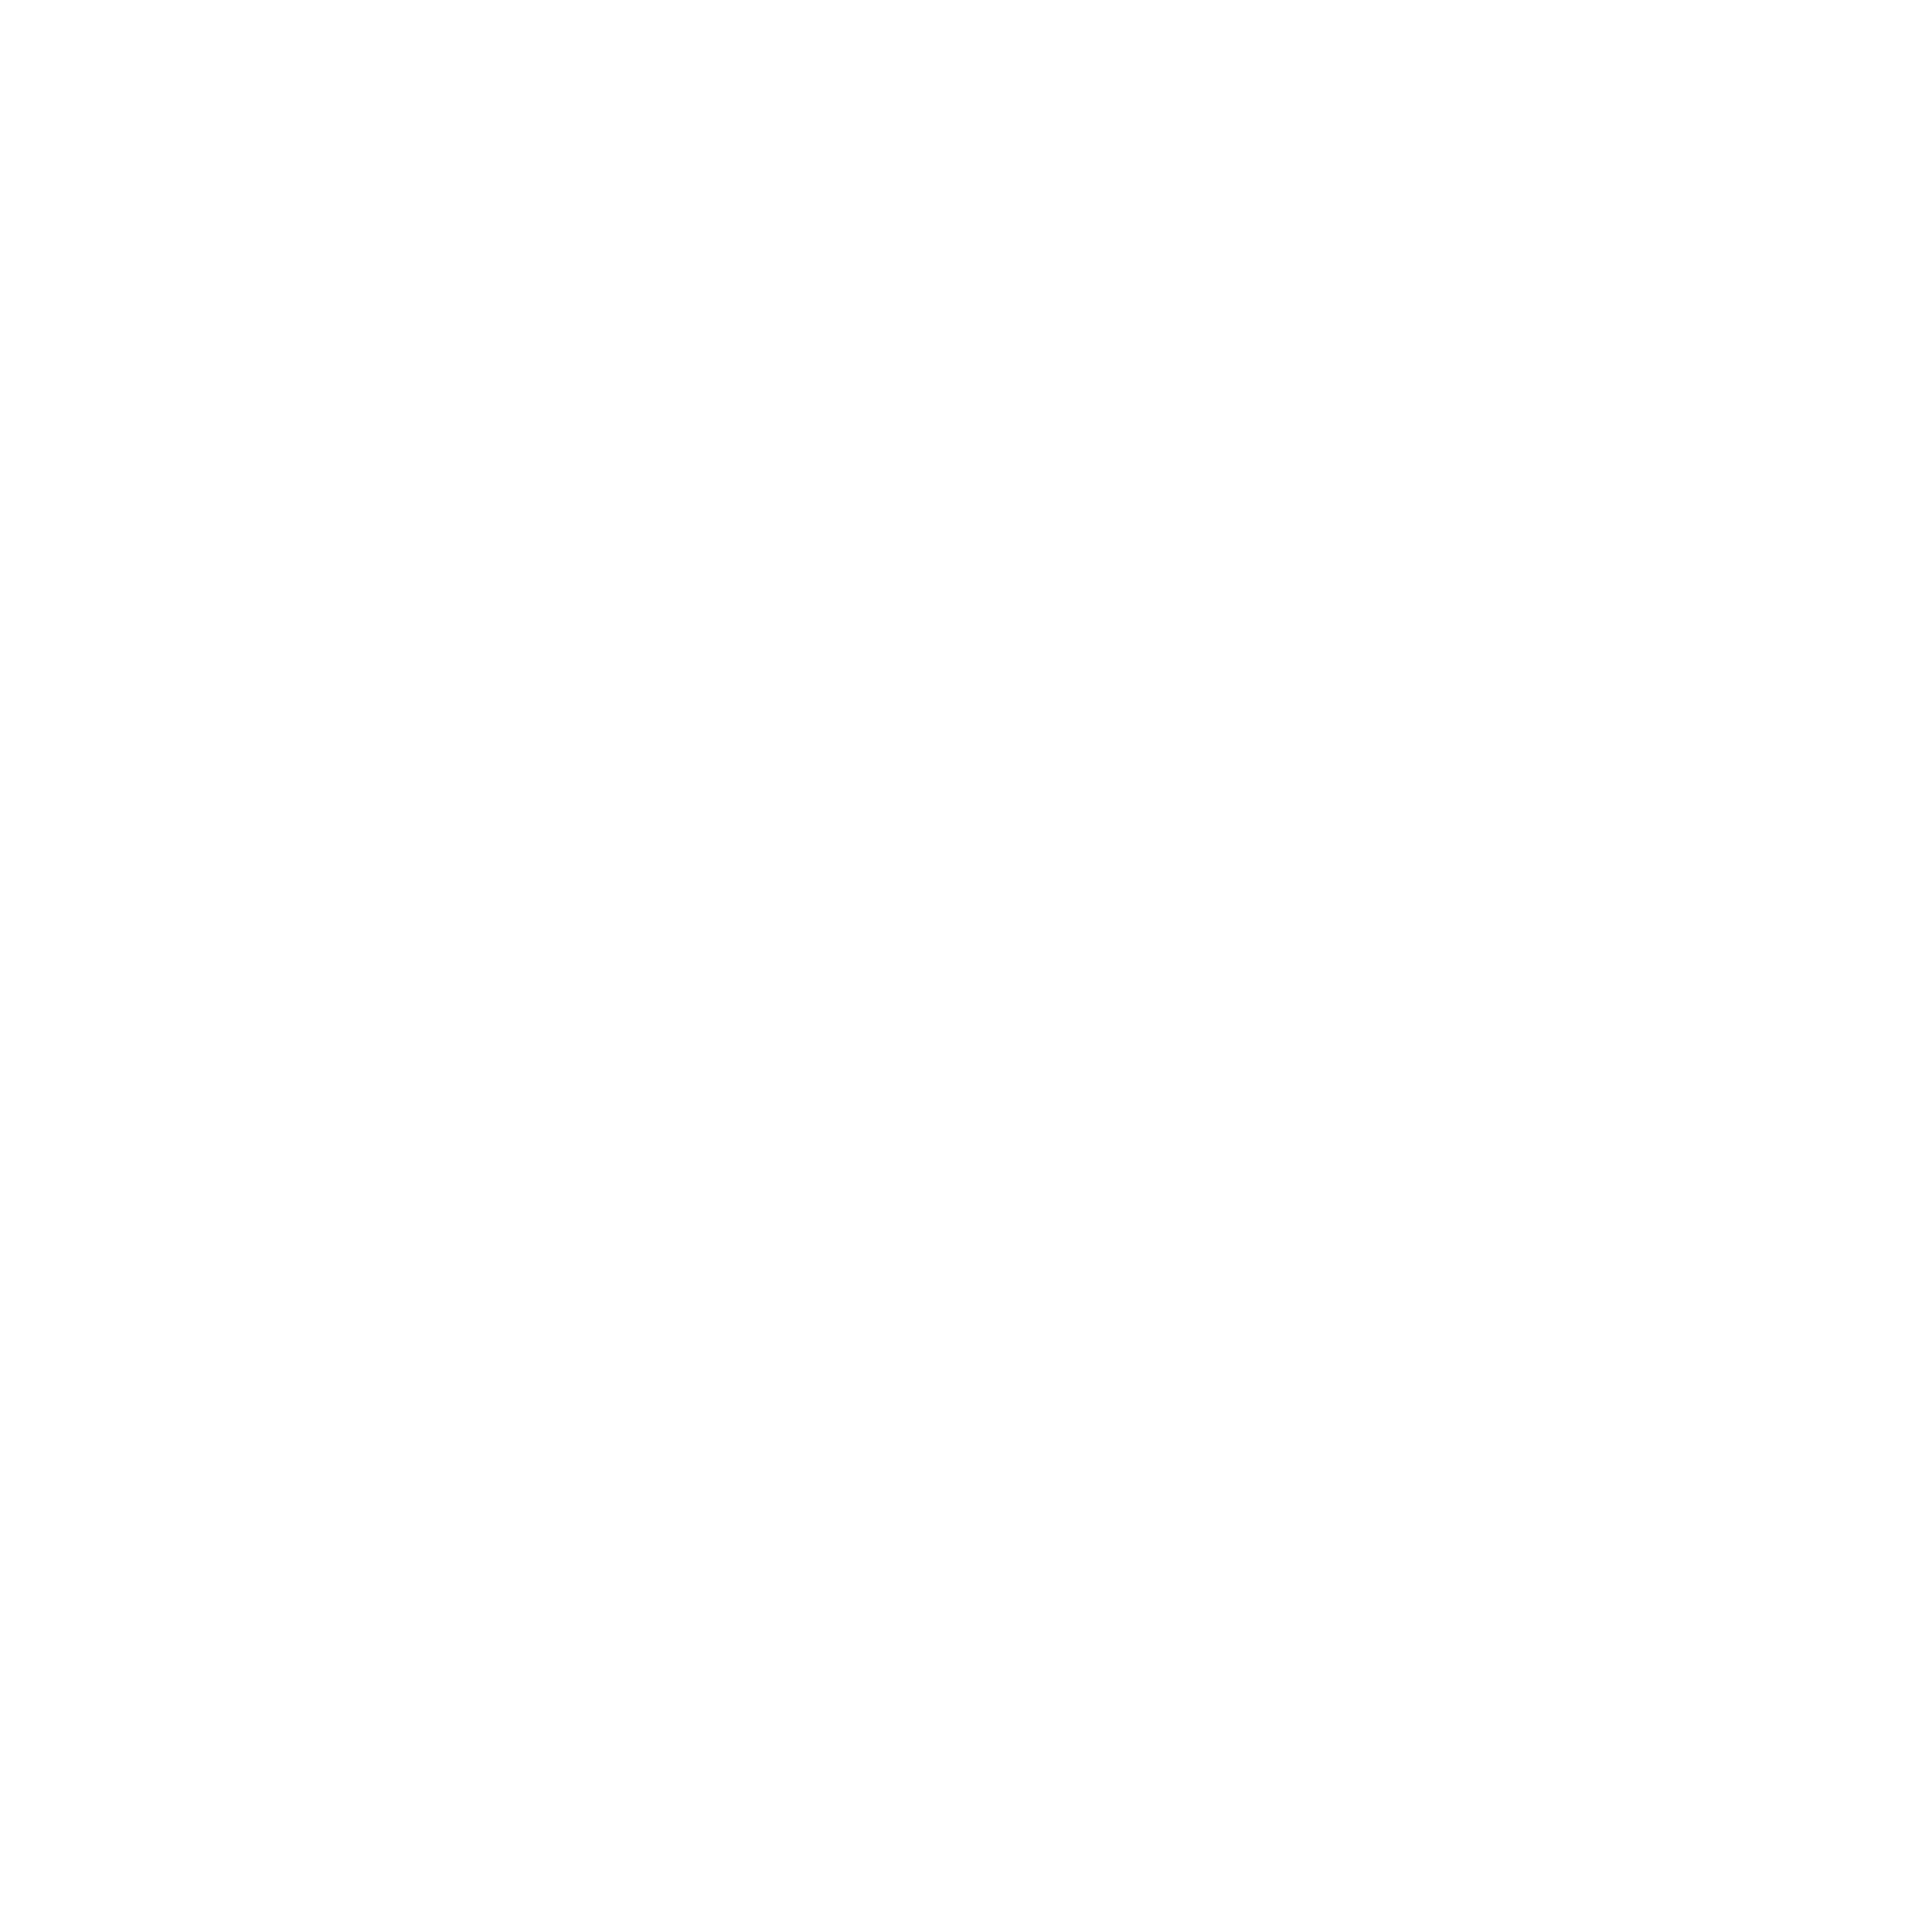

In [18]:
sns.set()
sns.scatterplot(data = combined_stg_df, x = "Stringency Index", y = "Total Deaths Per Million", color = "darkred",
                edgecolor = "none"
                ,alpha = 1, hue = "Country Income Level")

plt.title("Stringency Index vs Total Deaths Per Million")
plt.ylim(-5, 120)
plt.figure(figsize=(25,25))
plt.show()

In [19]:
#USA
usa = strigency_per_country[(strigency_per_country["Country"]== "United States") & (strigency_per_country["Date"] < '2020-06-15')]
usa.head()

,Country,Date,Total Cases,Total Cases Per Million,New Cases,Total Deaths Per Million,Total Deaths,Stringency Index,GDP Per Capita,Income Level,Continent
24098,United States,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,54225.446,High income,North America
24099,United States,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,54225.446,High income,North America
24100,United States,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,54225.446,High income,North America
24101,United States,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,54225.446,High income,North America
24102,United States,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,54225.446,High income,North America


<IPython.core.display.Javascript object>


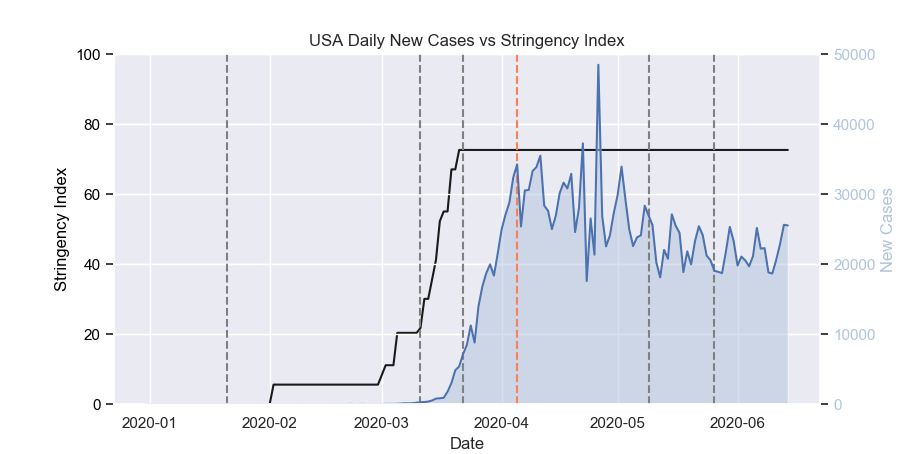

In [45]:
dates = usa["Date"].values.tolist()
usa_strigency_index=usa["Stringency Index"].values.tolist()
usa_new_cases=usa["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("USA Daily New Cases vs Stringency Index")

ax1.set_ylim([0,100])
ax2.set_ylim([0,50000])
#ax1.set_xlim(["2019-12-31", "2020-06-13"])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

# Plot horiontal lines
dates_important=["2020-03-11", "2020-01-21", "2020-03-22", "2020-04-05","2020-05-26", "2020-05-09", "2020-03-20"]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1') #who declares covid a pandemic 
plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1') #first US case confirmed
plt.vlines(dates_important_values[2], 0, 50000, colors='grey', linestyles='dashed', label='line1') #highest stringency index
plt.vlines(dates_important_values[3], 0, 50000, colors='coral', linestyles='dashed', label='line1') #two weeks after
plt.vlines(dates_important_values[4], 0, 50000, colors='grey', linestyles='dashed', label='line1') #floyd protest
plt.vlines(dates_important_values[5], 0, 50000, colors='grey', linestyles='dashed', label='line1') #mother's day
#plt.vlines(dates_important_values[5], 0, 50000, colors='grey', linestyles='dashed', label='line1') first day of spring

plt.savefig("../Images/USA_linechart.png")
plt.show()

<IPython.core.display.Javascript object>


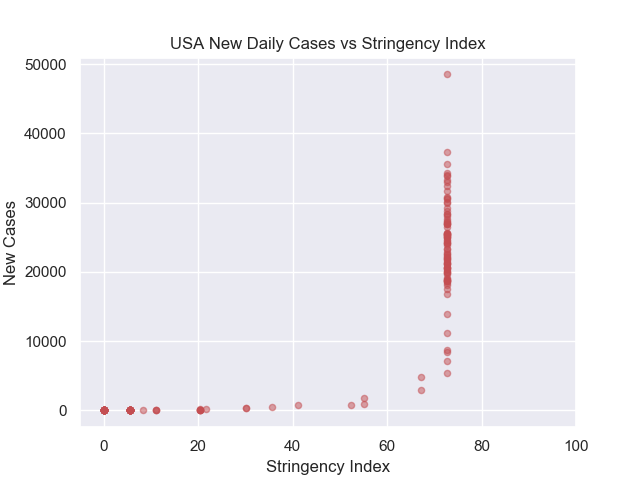

In [35]:
usa.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("USA New Daily Cases vs Stringency Index")
plt.xlim(-5, 100)
plt.savefig("../Images/USA_scatterplot.png")
plt.show()

In [36]:
#Germany
germany = strigency_per_country[(strigency_per_country["Country"]== "Germany") & (strigency_per_country["Date"] < "2020-06-14") ]

<IPython.core.display.Javascript object>


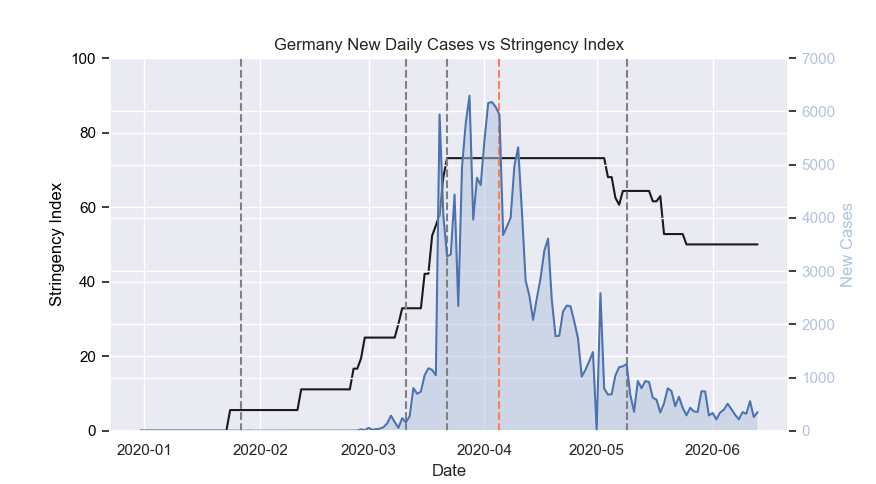

In [44]:
dates = germany["Date"].values.tolist()
usa_strigency_index=germany["Stringency Index"].values.tolist()
usa_new_cases=germany["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Germany New Daily Cases vs Stringency Index")


ax1.set_ylim([0,100])
ax2.set_ylim([0,7000])
#ax1.set_xlim(["2019-12-31", "2020-06-13"])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

dates_important=["2020-03-11","2020-01-27", "2020-03-22", "2020-04-05", "2020-05-09" ]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1') #who declares covid a pandemic 
plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1') #Germany registers its first case
plt.vlines(dates_important_values[2], 0, 50000, colors='grey', linestyles='dashed', label='line1') #The government tightens its lockdown
plt.vlines(dates_important_values[3], 0, 50000, colors='coral', linestyles='dashed', label='line1') #Two weeks after lockdown
plt.vlines(dates_important_values[4], 0, 50000, colors='grey', linestyles='dashed', label='line1') #Mother's Day

plt.savefig("../Images/Germany_linechart.png")

plt.show()

<IPython.core.display.Javascript object>


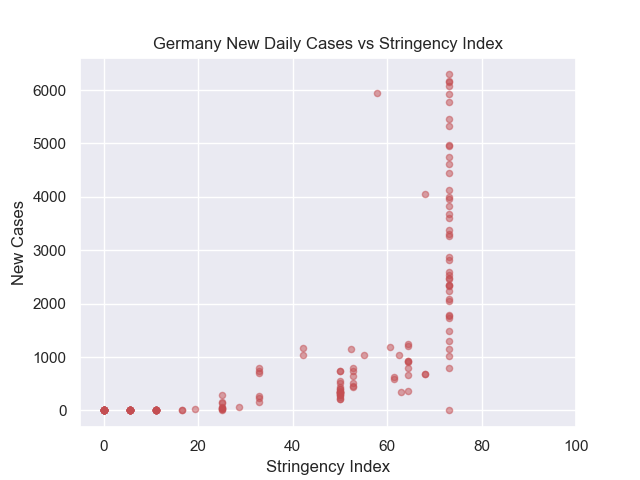

In [52]:
germany.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("Germany New Daily Cases vs Stringency Index")
plt.xlim(-5,100)
plt.savefig("../Images/Germany_scatterplot.png")
plt.show()


In [47]:
sweden = strigency_per_country[(strigency_per_country["Country"]== "Sweden")&(strigency_per_country["Date"] < "2020-06-08")]

<IPython.core.display.Javascript object>


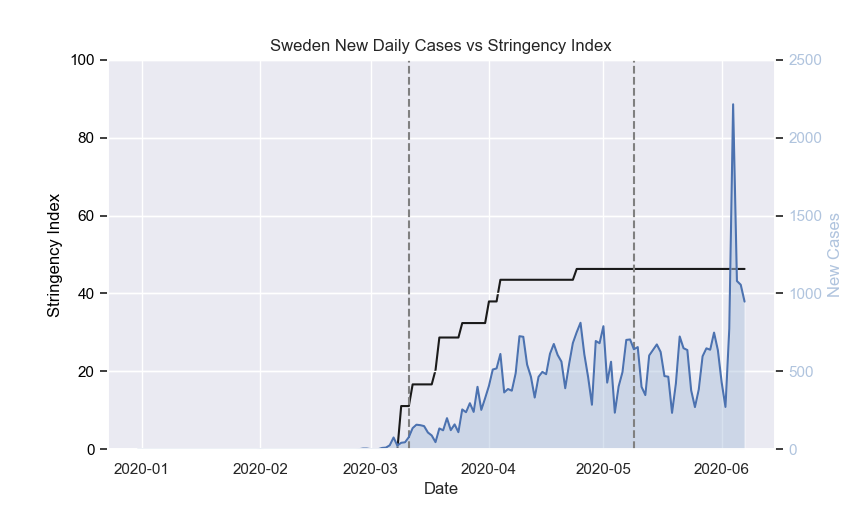

In [49]:
dates = sweden["Date"].values.tolist()
usa_strigency_index=sweden["Stringency Index"].values.tolist()
usa_new_cases=sweden["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Sweden New Daily Cases vs Stringency Index")


ax1.set_ylim([0,100])
ax2.set_ylim([0,2500])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

dates_important=["2020-03-11", "2020-05-09"]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1') #who declares covid a pandemia
plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1') #mother's day

plt.savefig("../Images/Sweden_linechart.png")

plt.show()

<IPython.core.display.Javascript object>


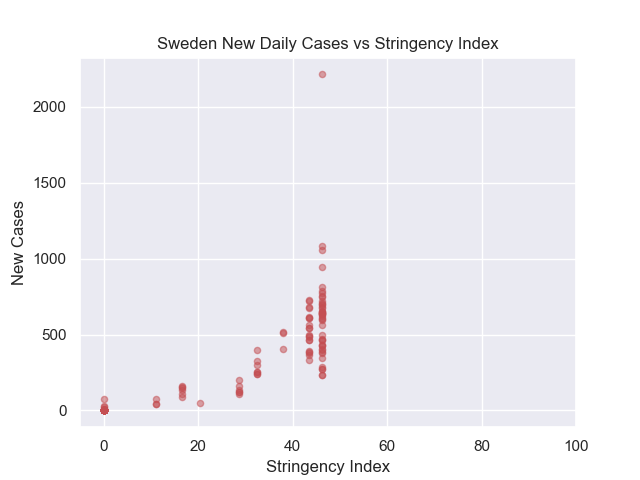

In [53]:
sweden.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("Sweden New Daily Cases vs Stringency Index")
plt.xlim(-5,100)
plt.savefig("../Images/Sweden_scatterplot.png")
plt.show()



In [50]:
canada = strigency_per_country[(strigency_per_country["Country"]== "Canada")&(strigency_per_country["Date"] < "2020-06-12")]

<IPython.core.display.Javascript object>


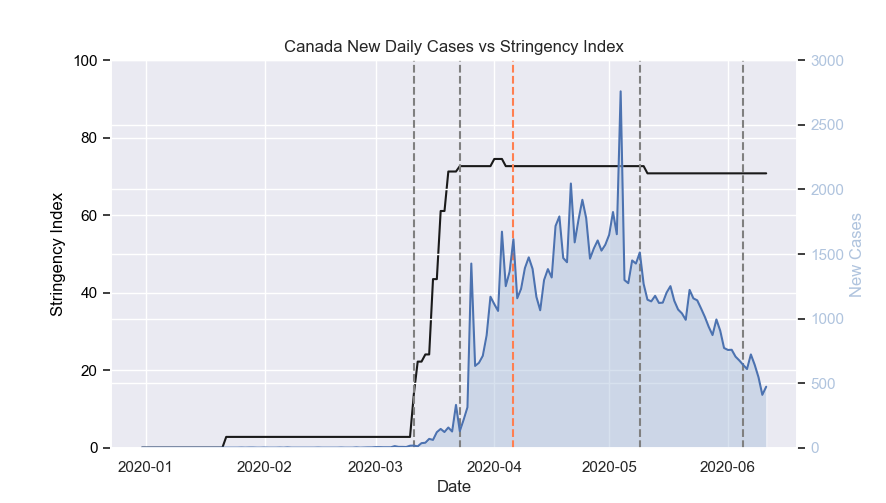

In [56]:
dates = canada["Date"].values.tolist()
usa_strigency_index=canada["Stringency Index"].values.tolist()
usa_new_cases=canada["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Canada New Daily Cases vs Stringency Index")

ax1.set_ylim([0,100])
ax2.set_ylim([0,3000])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

dates_important=["2020-03-11", "2020-03-23", "2020-04-06", "2020-05-09", "2020-06-05"]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1') #who
plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1') #high stringency index
plt.vlines(dates_important_values[2], 0, 50000, colors='coral', linestyles='dashed', label='line1') #two weeks after
plt.vlines(dates_important_values[3], 0, 50000, colors='grey', linestyles='dashed', label='line1') #mother's day
plt.vlines(dates_important_values[4], 0, 50000, colors='grey', linestyles='dashed', label='line1') #blm


plt.savefig("../Images/Canada_linechart.png")

plt.show()

<IPython.core.display.Javascript object>


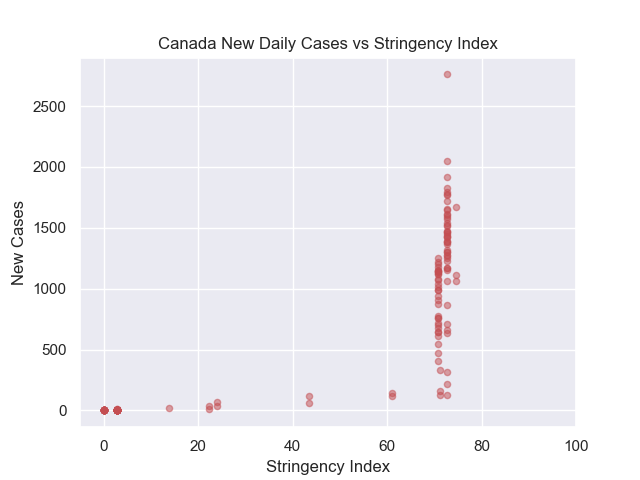

In [58]:
canada.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("Canada New Daily Cases vs Stringency Index")
plt.xlim(-5,100)
plt.savefig("../Images/Caanada_scatterplot.png")
plt.show()

In [57]:
peru = strigency_per_country[(strigency_per_country["Country"]== "Peru")&(strigency_per_country["Date"] < "2020-06-21")]

<IPython.core.display.Javascript object>


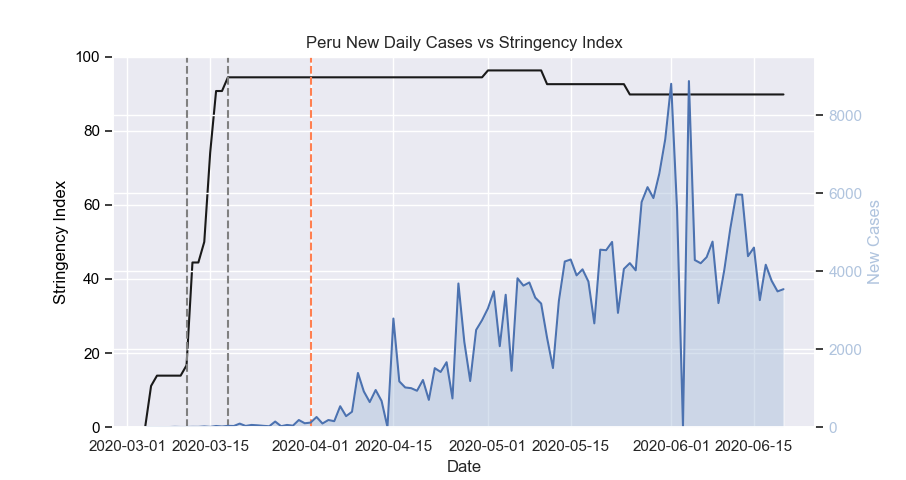

In [61]:
dates = peru["Date"].values.tolist()
usa_strigency_index=peru["Stringency Index"].values.tolist()
usa_new_cases=peru["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Peru New Daily Cases vs Stringency Index")

ax1.set_ylim([0,100])
ax2.set_ylim([0,9500])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

dates_important=["2020-03-11", "2020-03-18", "2020-04-01"]
dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1')
plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1')
plt.vlines(dates_important_values[2], 0, 50000, colors='coral', linestyles='dashed', label='line1')

plt.savefig("../Images/Peru_linechart.png")

plt.show()


<IPython.core.display.Javascript object>


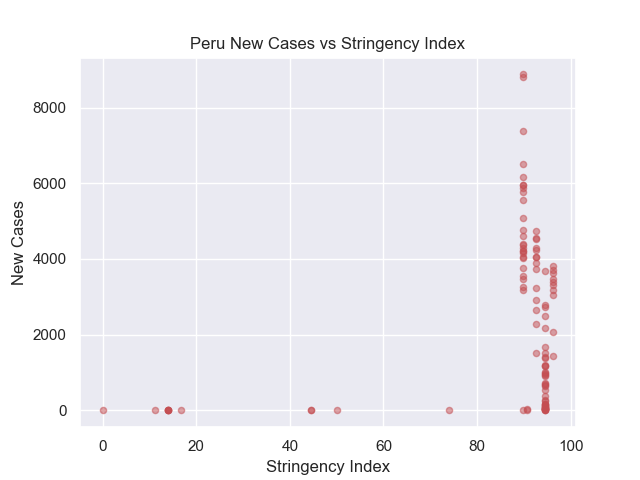

In [29]:
peru.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("Peru New Cases vs Stringency Index")
plt.xlim()
plt.savefig("../Images/Peru_scatterplot.png")
plt.show()

In [65]:
italy = strigency_per_country[(strigency_per_country["Country"]== "Italy")&(strigency_per_country["Date"] < "2020-06-12")]

<IPython.core.display.Javascript object>


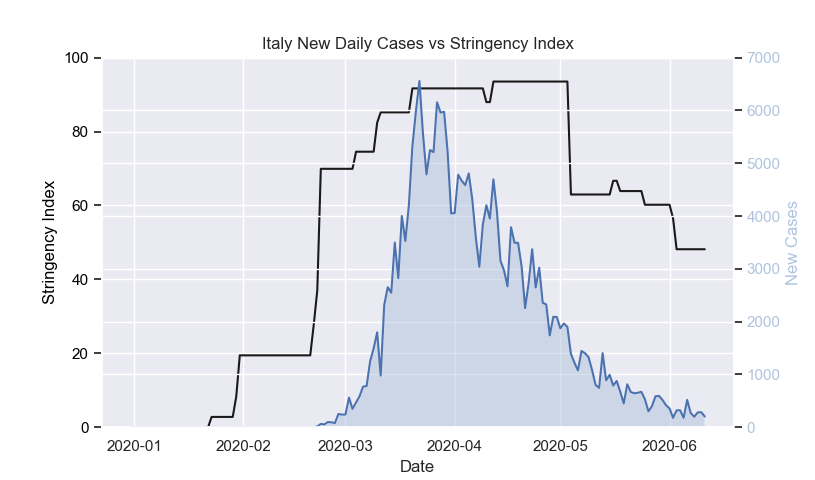

In [68]:
dates = italy["Date"].values.tolist()
usa_strigency_index=italy["Stringency Index"].values.tolist()
usa_new_cases=italy["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Italy New Daily Cases vs Stringency Index")


ax1.set_ylim([0,100])
ax2.set_ylim([0,7000])
#ax1.set_xlim(["2019-12-31", "2020-06-13"])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

#dates_important=["2020-03-21", "2020-05-09"]
#dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

#plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1')
#plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1')

plt.savefig("../Images/Italy_linechart.png")

plt.show()


<IPython.core.display.Javascript object>


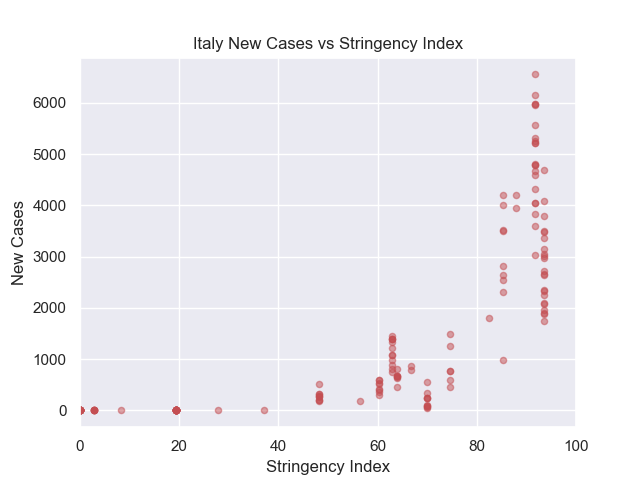

In [69]:
italy.plot(kind="scatter",y = "New Cases", x = "Stringency Index", c="r", alpha=0.5)
#plt.ylim(-70, 4000)
plt.title("Italy New Cases vs Stringency Index")
plt.xlim(0,100)
plt.savefig("../Images/Italy_scatterplot.png")
plt.show()

In [64]:
new_zealand = strigency_per_country[(strigency_per_country["Country"]== "New Zealand")&(strigency_per_country["Date"] < "2020-06-19")]



<IPython.core.display.Javascript object>


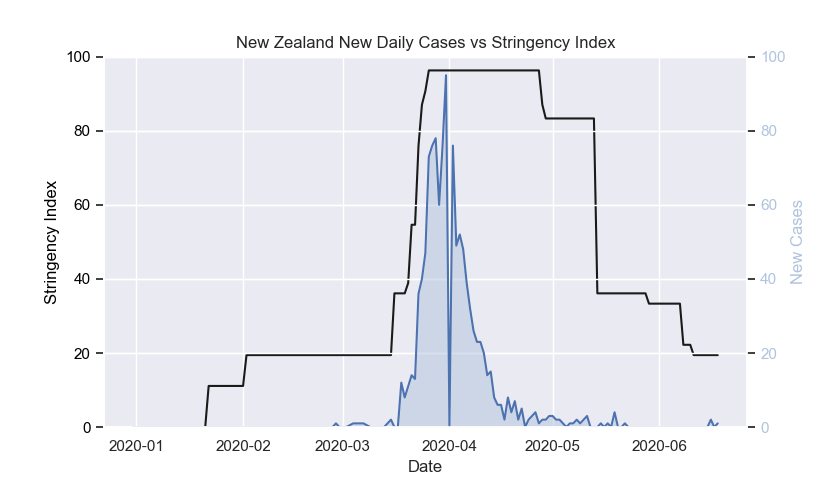

In [68]:
dates = new_zealand["Date"].values.tolist()
usa_strigency_index=new_zealand["Stringency Index"].values.tolist()
usa_new_cases=new_zealand["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("New Zealand New Daily Cases vs Stringency Index")


ax1.set_ylim([0,100])
ax2.set_ylim([0,100])
#ax1.set_xlim(["2019-12-31", "2020-06-13"])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

#dates_important=["2020-03-21", "2020-05-09"]
#dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

#plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1')
#plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1')

plt.savefig("../Images/New_zealand_linechart.png")

plt.show()

In [72]:
chile = strigency_per_country[(strigency_per_country["Country"]== "Chile")&(strigency_per_country["Date"] < "2020-06-11")]

<IPython.core.display.Javascript object>


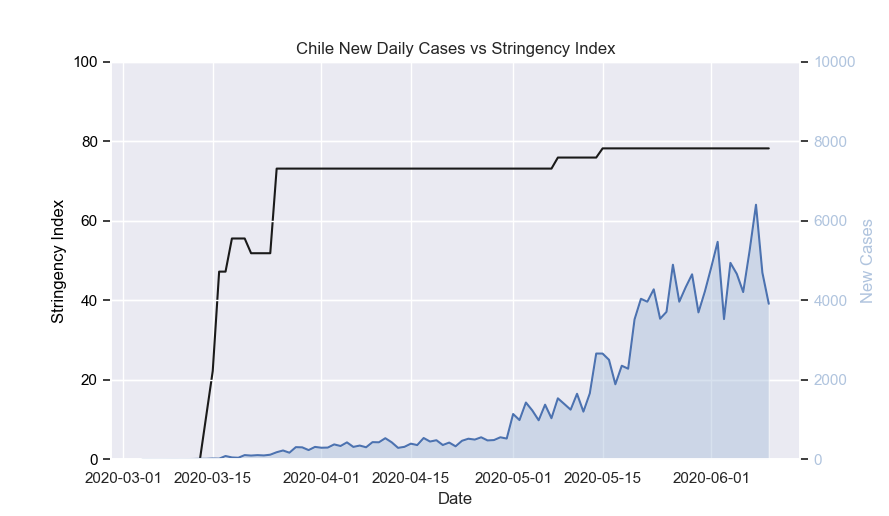

In [73]:
dates = chile["Date"].values.tolist()
usa_strigency_index=chile["Stringency Index"].values.tolist()
usa_new_cases=chile["New Cases"].values.tolist()
dates_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()

#Plot bars
ax1.plot(dates_values, usa_strigency_index, "k-")
ax1.set_xlabel('Date')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Stringency Index', color='black')
[tl.set_color('black') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(dates_values, usa_new_cases, "b-")


# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel("New Cases", color="lightsteelblue")
[tl.set_color("lightsteelblue") for tl in ax2.get_yticklabels()]

plt.title("Chile New Daily Cases vs Stringency Index")


ax1.set_ylim([0,100])
ax2.set_ylim([0,10000])
#ax1.set_xlim(["2019-12-31", "2020-06-13"])

ax2.fill_between(dates_values,0,usa_new_cases,facecolor='lightsteelblue', alpha = 0.5)

#dates_important=["2020-03-21", "2020-05-09"]
#dates_important_values=[datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates_important]

#plt.vlines(dates_important_values[0], 0, 50000, colors='grey', linestyles='dashed', label='line1')
#plt.vlines(dates_important_values[1], 0, 50000, colors='grey', linestyles='dashed', label='line1')

plt.savefig("../Images/Chile_linechart.png")

plt.show()